In [78]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#set same inputs and initial conditions


dt              = 1.0/400.0

wheel_brace     = 78.0
wheel_diameter  = 28.0

tau_forward     = 1.5
tau_turn        = 1.5


mat_a = numpy.zeros((4, 4))
mat_b = numpy.zeros((4, 2))

mat_a[0][2] = 1.0
mat_a[1][3] = 1.0
mat_a[2][2] = -1.0/tau_forward
mat_a[3][3] = -1.0/tau_turn


mat_b[2][0] = (wheel_diameter)/tau_forward
mat_b[3][1] = (wheel_diameter/wheel_brace)/tau_turn

# create continuous dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, None, dt)

print(mat_a)
print(mat_b)


# discretise system
a_est, b_est, c_est = LibsControl.c2d(ds.a, ds.b, ds.c, dt)




[[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.         -0.66666667  0.        ]
 [ 0.          0.          0.         -0.66666667]]
[[ 0.          0.        ]
 [ 0.          0.        ]
 [18.66666667  0.        ]
 [ 0.          0.23931624]]


In [79]:
#controller synthetis

#create loss weighting matrices (diagonal)
q = numpy.diag([ 1.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [1.0, 1.0])  

#solve LQR controller 
lqr = LibsControl.LQRDiscrete(a_est, b_est, q, r)

    
print("controller")
print("k  = \n", lqr.k, "\n")
print("ki  = \n", lqr.ki, "\n")
print("\n\n")



print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqr.k))



def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str

print(matrix_to_c("k", lqr.k))
print(matrix_to_c("ki",  lqr.ki))

controller
k  = 
 [[ 42.957544     0.           2.10908469   0.        ]
 [  0.         177.06725186   0.          35.76905631]] 

ki  = 
 [[1.04921198 0.         0.         0.        ]
 [0.         1.01070015 0.         0.        ]] 




poles OL =  [1.         1.         0.99833472 0.99833472]
poles CL =  [0.94874448+0.04878946j 0.94874448-0.04878946j 0.98840997+0.01141468j
 0.98840997-0.01141468j]
float k[] = {
		42.957542, 0.0, 2.1090846, 0.0, 
		0.0, 177.06725, 0.0, 35.769054 };

float ki[] = {
		1.049212, 0.0, 0.0, 0.0, 
		0.0, 1.0107001, 0.0, 0.0 };



'\nplt.plot(du_result[:, 0], label="du[0] change")\nplt.plot(du_result[:, 1], label="du[1] change")\nplt.show()\n'

<Figure size 640x480 with 0 Axes>

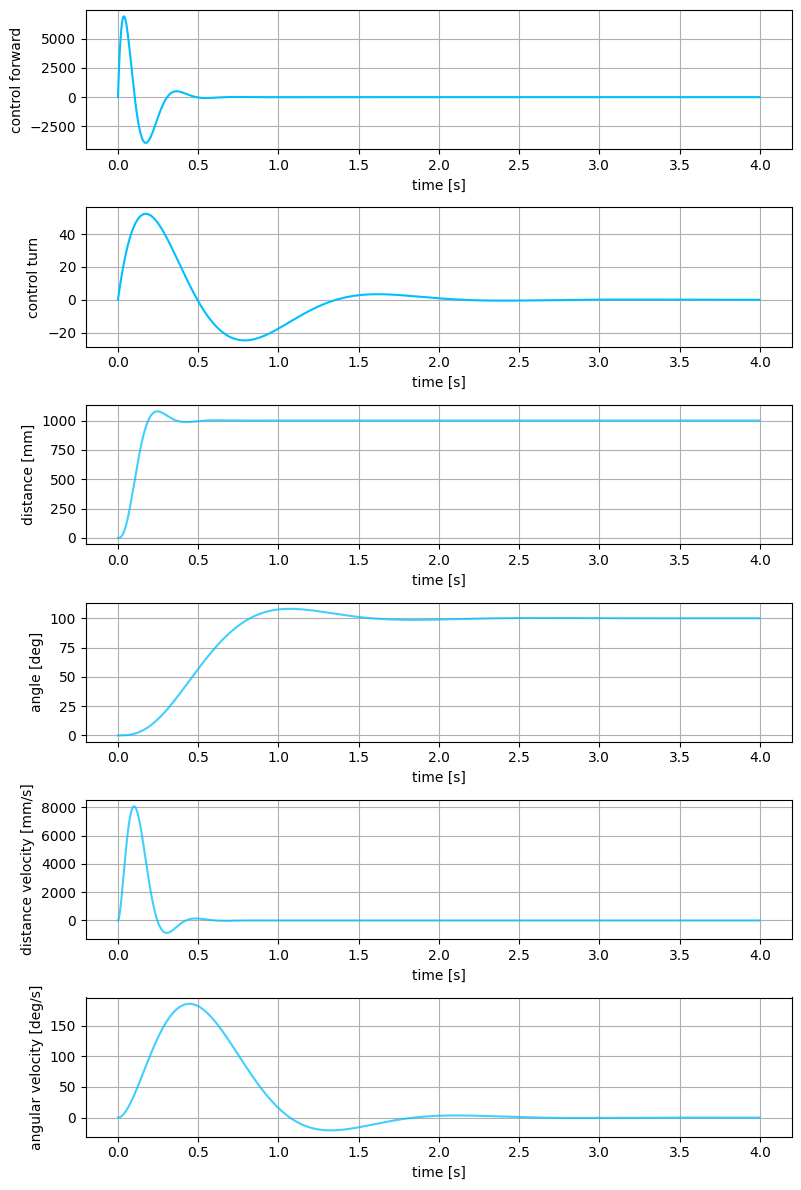

In [80]:
#process simulation
n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T

#plant state
x = numpy.zeros((a_est.shape[0], 1))

#result log
t_result = [] 
u_result = []
x_result = []

u = numpy.zeros((2, 1))
integral_action = numpy.zeros((2, 1))

for n in range(n_max):

    #compute controller output
    u, integral_action = lqr.forward(xr, x, integral_action)


    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

 

    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)

x_result = numpy.array(x_result)


du_result = x_result[1:, :] - x_result[0:-1, :]

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 
x_result[:, 3]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_controller_output.png", u_labels = ["control forward", "control turn"], x_labels = ["distance [mm]", "angle [deg]", "distance velocity [mm/s]", "angular velocity [deg/s]"])

'''
plt.plot(du_result[:, 0], label="du[0] change")
plt.plot(du_result[:, 1], label="du[1] change")
plt.show()
'''
